In [1]:
import json
import re 
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import time
from gensim.models import Word2Vec
from gensim.models.wrappers.fasttext import FastText
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import mpld3
from sklearn.preprocessing import MinMaxScaler

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# Data cleaning 

### Ingredients are constructed out of multiple words - sometimes it leads to undesired result such as essentialy the same ingredient being treated as different (e.x. powdered black pepper vs black pepper)
### Most rare of such words will be dropped

In [2]:
#load files 
    #no separation between train and test since we are using these for a completely different purpose
recipesJson=json.loads(open("E:/Downloads/train.json").read())
recipesJson2=json.loads(open("E:/Downloads/test.json").read())

In [3]:
#Parse for ingredients only
recipes=[x['ingredients'] for x in recipesJson+recipesJson2]

In [4]:
#Total Recipes in the data 
len(recipes)

49718

In [5]:
#Clean out non-letter or space symbols and collapse the list into a collection of ingredients
regex=re.compile('[^a-zA-Z ]')

ingredientsFull=[regex.sub('',item.lower()).strip() for sublist in recipes for item in sublist]

In [6]:
uniqueIngredients=(np.unique(ingredientsFull))

In [7]:
len(uniqueIngredients)

7112

In [8]:
#Look at words in the data to clean unnecessary differentiators
words=[x for item in uniqueIngredients for x in item.split(' ') if len(x)>1]


In [9]:
len(words)

17052

In [10]:
#Construct a frequence dictionary and create a dataset of words to drop
uniqueFrequencies = {i:words.count(i) for i in words}
dropWords=[k for k in uniqueFrequencies.keys() if uniqueFrequencies[k]==1]\
+['yellow','black','red','green','white','purple','cloves','and','cook','drain','allpurpose','purpose','all','pitted','crumbles','powder']

In [11]:
len(dropWords)

1615

# Using different Word2Vec settings to obtained diverse representations of the data 

## Using CBOW Wor2Vec on Ingredients Phrases

In [12]:
#Use the dropWords to clean the data and call word2vec on the resulting recipes
#Reread the data and clean out unnecessary symbols 
recipes=[[regex.sub('',item.lower()).strip() for item in x['ingredients']] for x in recipesJson+recipesJson2]

#Disects ingredients into subwords, drops the unnecessary ones and rejoins the remaining ones into a string
recipes=[[' '.join([subword for subword in ingredient.split(' ') if subword not in dropWords and len(subword)>2]).strip()\
          for ingredient in recipe] for recipe in recipes]
#Get rid of duplicated ingredients and make sure ingredients have at least more than 1 symbol in them
recipes=[list(np.unique([ingredient for ingredient in recipe if len(ingredient)>1]))\
             for recipe in recipes]


In [13]:
recipes[0]

['feta cheese',
 'garbanzo beans',
 'garlic',
 'grape tomatoes',
 'olives',
 'onion',
 'pepper',
 'romaine lettuce',
 'seasoning']

In [14]:
#Observe a drop in unique Ingredients as desired 
ingredientsFull=[item for sublist in recipes for item in sublist]
uniqueIngredients=(np.unique(ingredientsFull))

In [15]:
len(uniqueIngredients)

5590

In [16]:
#Construct word2vec on the recipes. 
    # Window is very high since we want to predict all of the ingredients in the recipe and not just the surrounding ones
model = Word2Vec(recipes, size=40, window=15, min_count=5, workers=4,iter=5)
word_vectors = model.wv.syn0
word_vectors=MinMaxScaler().fit_transform(word_vectors)


In [17]:
#Check some interesting combinations
model.wv.most_similar_cosmul(positive=['salt','pepper'])

[('salt ground pepper', 0.5543782711029053),
 ('marjoram', 0.4144362509250641),
 ('hungarian paprika', 0.4129519760608673),
 ('tomato pure', 0.41248825192451477),
 ('vegetable broth', 0.4123281240463257),
 ('kidney beans', 0.41138842701911926),
 ('puy lentils', 0.4101575016975403),
 ('tomato paste', 0.4082837700843811),
 ('tomatoes with juice', 0.4073372483253479),
 ('nosaltadded diced tomatoes', 0.40419885516166687)]

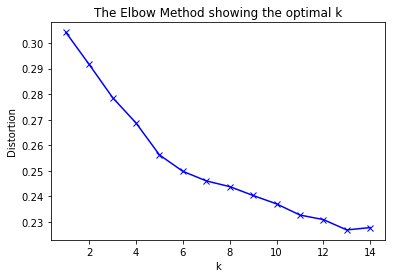

In [18]:
#Use Elbow method to determine optimal number of clusters
# https://pythonprogramminglanguage.com/kmeans-elbow-method/
plt.figure()
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(word_vectors)
    distortions.append(sum(np.min(cdist(word_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / word_vectors.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
 

In [19]:

num_clusters = 5
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )


In [20]:
#Zip words with their cluster asssignment
assignments=list(zip(model.wv.index2word,idx))

In [21]:
assignments[0:20]

[('salt', 0),
 ('garlic', 0),
 ('onions', 2),
 ('olive oil', 1),
 ('pepper', 0),
 ('sugar', 3),
 ('water', 0),
 ('flour', 3),
 ('ground pepper', 1),
 ('butter', 3),
 ('vegetable oil', 0),
 ('onion', 2),
 ('eggs', 0),
 ('tomatoes', 0),
 ('soy sauce', 4),
 ('bell pepper', 2),
 ('kosher salt', 0),
 ('large eggs', 3),
 ('carrots', 4),
 ('unsalted butter', 3)]

In [22]:
#Check cluster sizes
[len([k for k,v in assignments if v==i]) for i in range(0,num_clusters)]


[2312, 193, 139, 174, 160]

In [23]:
#Look at specific clusters. This one definitely looks like Asian cuisine to me!
[k for k,v in assignments if v==4]


['soy sauce',
 'carrots',
 'oil',
 'ginger',
 'corn starch',
 'sesame oil',
 'brown sugar',
 'fresh ginger',
 'lime',
 'fresh lime juice',
 'fish sauce',
 'canola oil',
 'rice vinegar',
 'cilantro leaves',
 'lime juice',
 'chicken stock',
 'ground turmeric',
 'cumin seed',
 'garam masala',
 'rice',
 'vinegar',
 'coconut milk',
 'cucumber',
 'curry',
 'ground coriander',
 'sesame seeds',
 'peppercorns',
 'chilies',
 'tumeric',
 'cabbage',
 'ground ginger',
 'coriander',
 'chili peppers',
 'cinnamon sticks',
 'clove',
 'peanut oil',
 'peeled fresh ginger',
 'cooked rice',
 'lime wedges',
 'cooking oil',
 'mustard seeds',
 'oyster sauce',
 'fresh mint',
 'pork',
 'low sodium soy sauce',
 'plain yogurt',
 'hoisin sauce',
 'spring onions',
 'peanuts',
 'chickpeas',
 'coriander seeds',
 'lemongrass',
 'boneless chicken skinless thigh',
 'toasted sesame oil',
 'light soy sauce',
 'chiles',
 'fresh ginger root',
 'basmati rice',
 'shiitake',
 'serrano chile',
 'dark soy sauce',
 'curry paste',

In [25]:
#Reduce the vectors to 2 dimensions to be able to plot the clusters
reduced=TSNE(2,perplexity=30).fit_transform(word_vectors)

In [26]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(facecolor='#EEEEEE'))
scatter = ax.scatter(reduced[:,0],
                     reduced[:,1],
                     c=idx/(1.0+num_clusters),
                     s=100,
                     alpha=0.3,
                     cmap=plt.cm.tab10)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = model.wv.index2word
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.enable_notebook
mpld3.display()

### Increase the number of iterations and separations are much smoother and closer to ingredient level 

In [27]:
#Construct word2vec on the recipes. 
    # Window is very high since we want to predict all of the ingredients in the recipe and not just the surrounding ones
model = Word2Vec(recipes, size=40, window=15, min_count=5, workers=4,iter=100)
word_vectors = model.wv.syn0
word_vectors=MinMaxScaler().fit_transform(word_vectors)


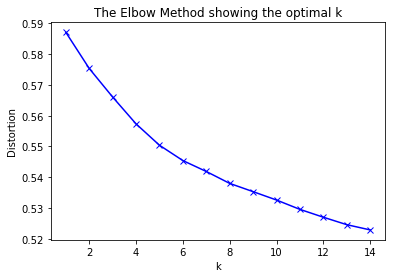

In [29]:
#Use Elbow method to determine optimal number of clusters
# https://pythonprogramminglanguage.com/kmeans-elbow-method/
plt.figure()
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(word_vectors)
    distortions.append(sum(np.min(cdist(word_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / word_vectors.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
 

In [30]:

num_clusters = 6
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )


In [31]:
#Zip words with their cluster asssignment
assignments=list(zip(model.wv.index2word,idx))

In [32]:
#Reduce the vectors to 2 dimensions to be able to plot the clusters
reduced=TSNE(2,perplexity=30).fit_transform(word_vectors)

In [33]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(facecolor='#EEEEEE'))
scatter = ax.scatter(reduced[:,0],
                     reduced[:,1],
                     c=idx/(1.0+num_clusters),
                     s=100,
                     alpha=0.3,
                     cmap=plt.cm.tab10)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = model.wv.index2word
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.enable_notebook
mpld3.display()

## Using Skipgram Wor2Vec on Ingredients Phrases

In [34]:
#sg parameter is set to 1 to use skipgram instead of CBOW
model = Word2Vec(recipes, size=40, window=15, min_count=5, workers=4,iter=10,sg=1)
word_vectors = model.wv.syn0
word_vectors=MinMaxScaler().fit_transform(word_vectors)


In [35]:
#Check
model.wv.most_similar_cosmul(positive=['salt','pepper'])

[('garlic', 0.734675943851471),
 ('water', 0.7090380191802979),
 ('minced garlic', 0.6923776865005493),
 ('ground pepper', 0.6882472634315491),
 ('vegetables', 0.6882340312004089),
 ('sauce', 0.6867583990097046),
 ('whole wheat thin spaghetti', 0.6760802268981934),
 ('onions', 0.672153115272522),
 ('powdered garlic', 0.6708405613899231),
 ('chicken noodle soup', 0.6644176244735718)]

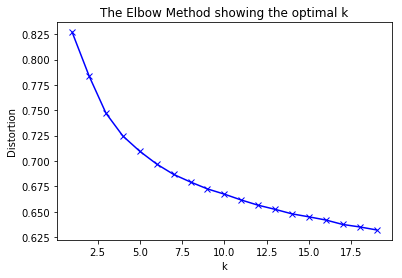

In [36]:
#Use Elbow method to determine optimal number of clusters
# https://pythonprogramminglanguage.com/kmeans-elbow-method/
plt.figure()
# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(word_vectors)
    distortions.append(sum(np.min(cdist(word_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / word_vectors.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
 

In [37]:

num_clusters = 6
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )


In [38]:
#Zip words with their cluster asssignment
assignments=list(zip(model.wv.index2word,idx))

In [39]:
assignments[0:20]

[('salt', 2),
 ('garlic', 2),
 ('onions', 2),
 ('olive oil', 3),
 ('pepper', 2),
 ('sugar', 1),
 ('water', 2),
 ('flour', 1),
 ('ground pepper', 2),
 ('butter', 1),
 ('vegetable oil', 2),
 ('onion', 2),
 ('eggs', 1),
 ('tomatoes', 2),
 ('soy sauce', 0),
 ('bell pepper', 2),
 ('kosher salt', 2),
 ('large eggs', 1),
 ('carrots', 2),
 ('unsalted butter', 1)]

In [40]:
#Check cluster sizes
[len([k for k,v in assignments if v==i]) for i in range(0,num_clusters)]
#Observe much more evenly distributed clusters 

[480, 551, 746, 449, 462, 290]

In [42]:
#Reduce the vectors to 2 dimensions to be able to plot the clusters
reduced=TSNE(2,perplexity=60).fit_transform(word_vectors)

In [43]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(facecolor='#EEEEEE'))
scatter = ax.scatter(reduced[:,0],
                     reduced[:,1],
                     c=idx/(1.0+num_clusters),
                     s=100,
                     alpha=0.3,
                     cmap=plt.cm.tab10)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = model.wv.index2word
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.enable_notebook
mpld3.display()
#Natural Separations are a little more mixed but follow specific cusines more closely

## Using ingredient words

### Very Similiar to the previous section but uses each word as a separate ingredient. 

In [44]:
recipes=[[regex.sub('',item.lower()).strip() for item in x['ingredients']] for x in recipesJson+recipesJson2]

#Separate each ingredient into a subword and drop the rare ones 
recipesWords=[[subword  for subword in ' '.join(recipe).split(' ') if subword not in dropWords and len(subword)>2]\
             for recipe in recipes]

recipesWords=[list(np.unique(recipe))\
             for recipe in recipesWords]


In [45]:
recipesWords[0]

['beans',
 'cheese',
 'feta',
 'garbanzo',
 'garlic',
 'grape',
 'lettuce',
 'olives',
 'onion',
 'pepper',
 'romaine',
 'seasoning',
 'tomatoes']

In [46]:
model = Word2Vec(recipesWords, size=30, window=15, min_count=5, workers=4,iter=20)
word_vectors = model.wv.syn0
word_vectors=MinMaxScaler().fit_transform(word_vectors)

In [47]:
model.wv.most_similar_cosmul(positive=['salt','sugar'])

[('water', 0.7221121191978455),
 ('vegetable', 0.6543661952018738),
 ('zest', 0.597710132598877),
 ('yams', 0.5883510112762451),
 ('table', 0.5882288813591003),
 ('vegetables', 0.5724589824676514),
 ('wine', 0.5597628355026245),
 ('wedges', 0.5546391010284424),
 ('vermicelli', 0.5525017976760864),
 ('stems', 0.550439715385437)]

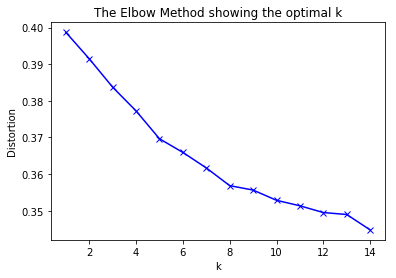

In [48]:
plt.figure()
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(word_vectors)
    distortions.append(sum(np.min(cdist(word_vectors, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / word_vectors.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
 

In [49]:
num_clusters = 8

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )


In [50]:
assignments=list(zip(model.wv.index2word,idx))

In [52]:
assignments[0:20]

[('salt', 4),
 ('oil', 5),
 ('pepper', 4),
 ('garlic', 7),
 ('ground', 7),
 ('fresh', 7),
 ('onions', 4),
 ('sugar', 4),
 ('olive', 1),
 ('sauce', 2),
 ('water', 4),
 ('chicken', 7),
 ('cheese', 6),
 ('butter', 0),
 ('flour', 5),
 ('tomatoes', 4),
 ('onion', 4),
 ('juice', 5),
 ('chopped', 7),
 ('eggs', 5)]

In [53]:
[len([k for k,v in assignments if v==i]) for i in range(0,num_clusters)]

[136, 94, 94, 38, 108, 703, 125, 90]

In [57]:
#Deserts?

[k for k,v in assignments if v==0]

['butter',
 'unsalted',
 'baking',
 'egg',
 'vanilla',
 'extract',
 'orange',
 'heavy',
 'nutmeg',
 'soda',
 'buttermilk',
 'granulated',
 'whipping',
 'almonds',
 'chocolate',
 'syrup',
 'ice',
 'powdered',
 'pecans',
 'peel',
 'golden',
 'confectioners',
 'apples',
 'cocoa',
 'shortening',
 'pastry',
 'dough',
 'sweetened',
 'cake',
 'almond',
 'peaches',
 'whiskey',
 'walnuts',
 'melted',
 'instant',
 'semisweet',
 'pie',
 'bananas',
 'rum',
 'packed',
 'strawberries',
 'coffee',
 'liqueur',
 'bourbon',
 'crust',
 'food',
 'brandy',
 'rind',
 'unbleached',
 'tartar',
 'tea',
 'puff',
 'raspberries',
 'whipped',
 'crme',
 'caster',
 'bittersweet',
 'cherries',
 'frache',
 'pears',
 'pecan',
 'sheets',
 'firmly',
 'gelatin',
 'maple',
 'hazelnuts',
 'berries',
 'phyllo',
 'fruit',
 'espresso',
 'concentrate',
 'pistachios',
 'unflavored',
 'blanched',
 'oats',
 'jam',
 'morsels',
 'blackberries',
 'cranberries',
 'blueberries',
 'oranges',
 'currants',
 'coloring',
 'preserves',
 'top

In [58]:
reduced=TSNE(2,perplexity=10).fit_transform(word_vectors)

In [60]:
fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(facecolor='#EEEEEE'))
scatter = ax.scatter(reduced[:,0],
                     reduced[:,1],
                     c=idx/(1.0+num_clusters),
                     s=100,
                     alpha=0.3,
                     cmap=plt.cm.tab10)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = model.wv.index2word
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.enable_notebook
mpld3.display()
#Much noisier distribution can be observed but some clusters are preserved